# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds given a SARS-CoV-2 assay. [Postera.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

Each model was constructed with a Pipeline of SMOTE and StandardScaler, which were used for rebalancing and scaling the data, respectively. Then, StratifiedKFold was used for training and cross-validating the model. Finally, roc_auc_score, geometric_mean_score and f2_score were used as metrics for choosing the best set of descriptors for each model (XGBClassifier, RandomForestClassifier, etc.). 

The best model was KNeighborsClassifier, which had the highest early recognition according to its ROC curve, followed by LinearDiscriminantAnalysis, LinearSVC and LogisticRegression, which produced similar results. XGBClassifier, DecisionTreeClassifier and RandomForestClassifier had the lowest roc_auc_score, though all models outperformed the models that considered only the docking scores. 

## Results
The results are presented in [this separate notebook](https://github.com/caiocrocha/COVID-19/blob/master/SARS-CoV-2/postera.ai/ML_results.ipynb).

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

0. [Imports](#imports)    
1. [Reading the data](#reading)    
    1. [Activity data](#activity)    
    2. [Molecular descriptors](#descriptors)
    3. [Read docking results](#read_docking)
2. [Selecting molecular descriptors](#selecting)
3. [Visualizing the data](#visualizing)
4. [Supplementary data](#supplementary)   
    1. [Regression plot](#regression)    
    2. [Test for class-independent features](#independent)

<a id='imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='reading'></a>
## Reading the data
<a id='activity'></a>
### Activity data

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.000000,0.660892
f_inhibition_at_50_uM,0.660892,1.000000


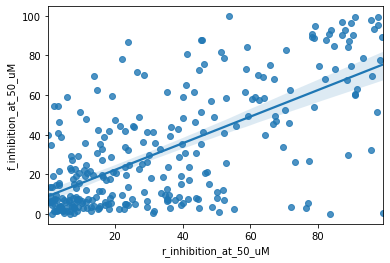

In [2]:
def write_data():
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open('activity_data.csv', 'wb') as f:
        f.write(r.content)

## Fetch activity data
#write_data()

# Read activity data
activity = pd.read_csv('activity_data.csv')
tmp = activity.query('r_inhibition_at_50_uM > 0 and r_inhibition_at_50_uM < 100 \
    and f_inhibition_at_50_uM > 0 and f_inhibition_at_50_uM < 100')

# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(data=tmp, x='r_inhibition_at_50_uM', y='f_inhibition_at_50_uM')
tmp[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

<AxesSubplot:xlabel='f_inhibition_at_50_uM', ylabel='Count'>

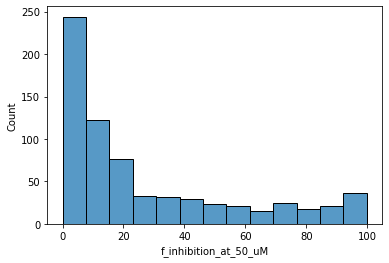

In [3]:
# Remove activators (inhibition < 0)
activity.dropna(subset=['f_inhibition_at_50_uM'], inplace=True)
activity = activity.query('f_inhibition_at_50_uM > 0 and f_inhibition_at_50_uM < 100')

# Label actives and inactives in relation to the fluorescence assay
activity['f_activity'] = activity['f_inhibition_at_50_uM'] > 50
activity['f_activity'] = activity['f_activity'].astype(int) # 1 for active, 0 for inactive

sns.histplot(x=activity['f_inhibition_at_50_uM'])

<a id='descriptors'></a>
### Molecular descriptors

In [4]:
def rdkit_2d_coordinates(activity):
    from rdkit import Chem
    # Write into smiles
    activity[['SMILES','CID']].to_csv('smiles.smi', sep=' ', index=False, header=None)
    suppl = Chem.SmilesMolSupplier('smiles.smi')
    # Compute 2D coordinates
    coordinates = [x for x in suppl if x is not None]
    return coordinates

def write_rdkit_descriptors(coordinates, descriptors_list, csv):
    from rdkit.Chem import Descriptors
    # Create dict of callable descriptors
    descriptors_dict = {}
    for name in descriptors_list:
        try:
            descriptor = eval(f'Descriptors.{name}')
            descriptors_dict[name] = descriptor
        except AttributeError as e:
            # Skip descriptor if it doesn't exist
            print(f'No module named Descriptors.{name}')
            continue
    
    # Check if descriptors_dict is empty
    if not bool(descriptors_dict):
        print('No descriptor to calculate')
        return
    
    list_all = []
    # Call descriptors for each molecule
    for mol in coordinates:
        d = {'CID': mol.GetProp('_Name')}
        for name, descriptor in descriptors_dict.items():
            try:
                d[name] = descriptor(mol)
            except Exception as e:
                print('Exception found, exiting function')
                print(str(e))
                return
        list_all.append(d)
    
    descriptors = pd.DataFrame(list_all)
    descriptors.to_csv(csv, index=False)

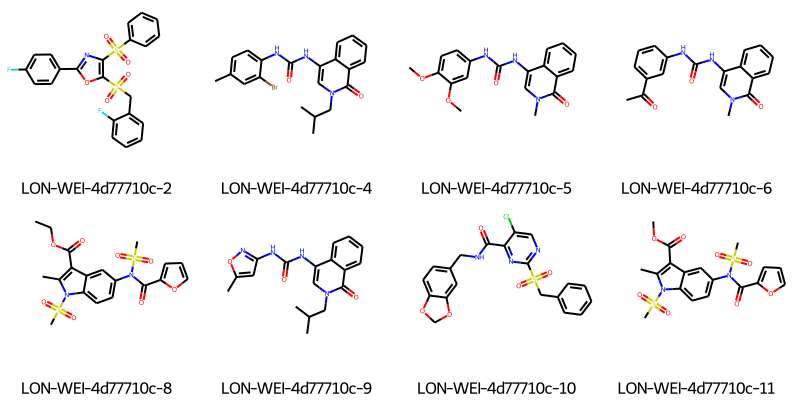

In [5]:
csv_descriptors = 'descriptors.csv'
coordinates = rdkit_2d_coordinates(activity)

# Write RDKit descriptors
rdkit_descriptors = ['MolMR','NumRotatableBonds','NumHAcceptors','NumHDonors','TPSA','LabuteASA','MolLogP']
write_rdkit_descriptors(coordinates, rdkit_descriptors, csv=csv_descriptors)

# Read descriptors
descriptors = pd.read_csv(csv_descriptors)
descriptors_list = list(descriptors.columns[1:])

# Draw
from rdkit.Chem import Draw
Draw.MolsToGridImage(coordinates[:8],
        molsPerRow=4,
        subImgSize=(200,200),
        legends=[x.GetProp("_Name") for x in coordinates[:8]])

<a id='read_docking'></a>
### Read docking results

In [6]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores
top = pd.merge(top_qvina, top_plants)

# Input data for the models
tmp = pd.merge(descriptors, top)
data = pd.merge(activity[['CID','f_activity']], tmp)
del tmp

data.head()

,CID,f_activity,MolMR,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants
0,MAT-POS-02ae579f-1,0,142.9562,8,3,1,62.55,216.479769,6.4632,-7.7,7.746907,-93.0745,7.544520
1,MAT-POS-02ae579f-2,0,73.8221,2,3,3,82.70,115.581247,1.5105,-7.2,6.285345,-80.1747,6.407342
2,LOR-NOR-f9b26152-1,0,45.9122,1,3,1,55.40,78.672385,0.9691,-5.5,4.929599,-59.7841,5.100658
3,MAT-POS-af71705c-2,0,121.0404,4,5,2,78.73,174.561548,4.0028,-8.3,7.213164,-80.6905,7.446774
4,JOH-UNI-591f77bd-1,0,90.8918,4,5,2,66.84,144.834380,2.5692,-5.9,6.262381,-75.5715,5.398284


<a id='selecting'></a>
## Selecting molecular descriptors

In [7]:
from sklearn.feature_selection import VarianceThreshold

y = data['f_activity']
X = data[descriptors_list]

var = VarianceThreshold(threshold=0.3)
var = var.fit(X, y)

# Select features with a high variance
cols = var.get_support(indices=True)
selected = X.columns[cols]
selected

Index(['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA',
       'LabuteASA', 'MolLogP'],
      dtype='object')

Text(0.5, 1.0, 'Correlation between the descriptors')

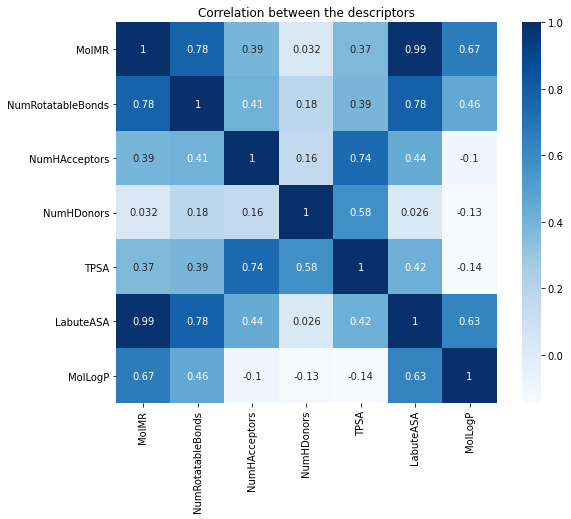

In [8]:
plt.figure(figsize=(9,7))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap='Blues', square=True)
plt.title('Correlation between the descriptors')

In [9]:
# Drop highly correlated features
data.drop(['MolMR'], axis=1, inplace=True)
descriptors_list.remove('MolMR')
data.to_csv('data.csv', index=False)

<a id='visualizing'></a>
## Visualizing the data

,f_activity,percentage
0,0,80.511182
1,1,19.488818


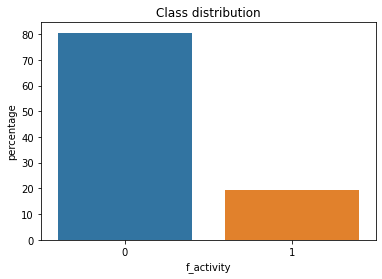

In [10]:
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']

trainset = descriptors_list + docking_list
data.dropna(subset=trainset, inplace=True)

distribution = data['f_activity'].value_counts(
    normalize=True).mul(100).reset_index().rename({'f_activity':'percentage','index':'f_activity'}, axis=1)

sns.barplot(data=distribution, x='f_activity', y='percentage')
plt.title('Class distribution')
distribution

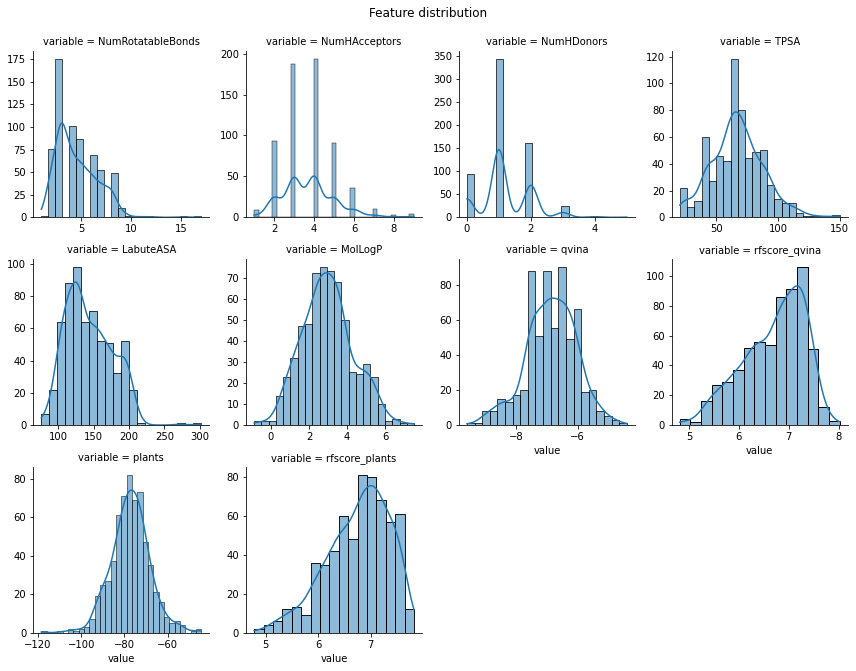

In [11]:
tmp = pd.melt(data, id_vars=['CID'], value_vars=trainset)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)
plt.suptitle('Feature distribution', y=1.03)
plt.savefig('distribution.png', dpi=216)

<a id='supplementary'></a>
## Supplementary data
<a id='regression'></a>
### Regression plot

Spearman R: 0.3712


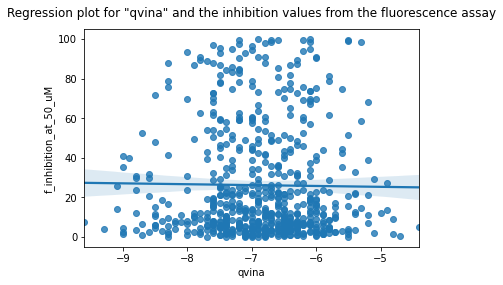

In [17]:
from scipy.stats import spearmanr

df = pd.merge(data[['CID','qvina']], activity[['CID','f_inhibition_at_50_uM']], on=['CID'])
df.dropna(subset=['qvina', 'f_inhibition_at_50_uM'], inplace=True)
print(f"Spearman R: {spearmanr(df['qvina'], df['f_inhibition_at_50_uM'])[1]:.4f}")

sns.regplot(data=df, x='qvina', y='f_inhibition_at_50_uM')
plt.title('Regression plot for "qvina" and the inhibition values from the fluorescence assay', y=1.03)
plt.savefig('regplot_qvina.png', dpi=128)

<a id='independent'></a>
### Test for class-independent features

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

y = data['f_activity']
X = MinMaxScaler().fit_transform(data[descriptors_list])
X = pd.DataFrame(X, columns=descriptors_list)

KBest = SelectKBest(score_func=chi2, k=5)
KBest = KBest.fit(X, y)

df_scores = pd.DataFrame({'features': X.columns, 'Chi2Score': KBest.scores_, 'pValue': KBest.pvalues_ })
df_scores

,features,Chi2Score,pValue
0,NumRotatableBonds,0.014771,0.903267
1,NumHAcceptors,0.744528,0.388214
2,NumHDonors,1.655536,0.198207
3,TPSA,1.498495,0.220903
4,LabuteASA,0.044402,0.833108
5,MolLogP,0.035720,0.850095


In [14]:
# Select features that are more likely to be related to the activity
cols = KBest.get_support(indices=True)
selected = X.columns[cols]
selected

Index(['NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA', 'MolLogP'], dtype='object')

Text(0.5, 1.0, 'Visualizing Important Features')

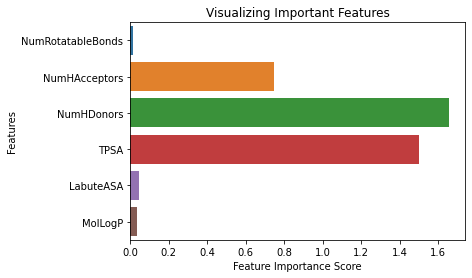

In [15]:
sns.barplot(x=df_scores['Chi2Score'], y=X.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')